#### Machine Learning Python


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
df = pd.read_csv('retail_daily_sales.csv')
df.head(5)

,OrderDate,TotalSales
0,2011-01-01,808.57
1,2011-01-02,314.22
2,2011-01-03,4503.54
3,2011-01-04,2808.87
4,2011-01-05,3662.31


In [3]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df = df.sort_values('OrderDate')


In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430 entries, 0 to 1429
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrderDate   1430 non-null   datetime64[ns]
 1   TotalSales  1430 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.5 KB
None
                           OrderDate    TotalSales
count                           1430   1430.000000
mean   2013-01-05 02:20:58.741258752   8840.910503
min              2011-01-01 00:00:00      2.690000
25%              2012-01-08 06:00:00   3794.657500
50%              2013-01-06 12:00:00   7700.140000
75%              2014-01-03 18:00:00  12466.367500
max              2014-12-31 00:00:00  39536.160000
std                              NaN   6570.117475


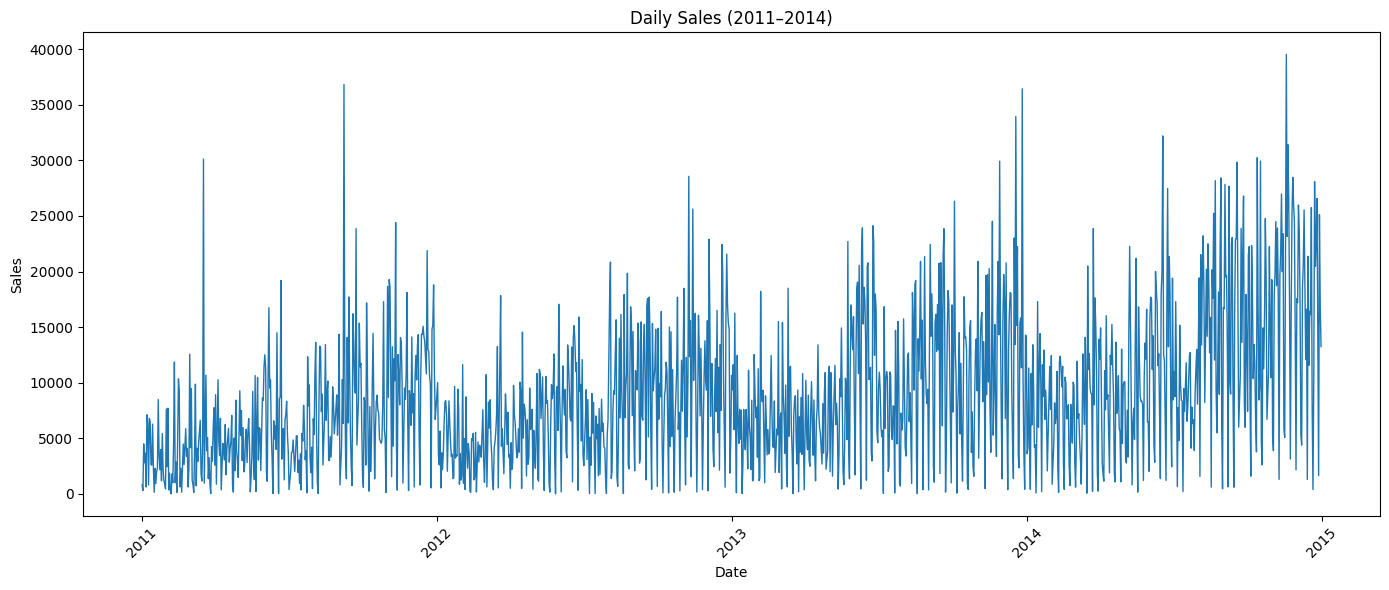

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


plt.figure(figsize=(14,6))
plt.plot(df['OrderDate'], df['TotalSales'], linewidth=1)
plt.title("Daily Sales (2011–2014)")
plt.xlabel("Date")
plt.ylabel("Sales")
# Format x-axis properly
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # show one tick per year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
from prophet import Prophet

In [ ]:
prophet_df = df[['OrderDate', 'TotalSales']].rename(
    columns={
        'OrderDate': 'ds',
        'TotalSales': 'y'
    }
)
print(prophet_df.head(5))

In [15]:
from prophet import Prophet

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(prophet_df)


11:56:41 - cmdstanpy - INFO - Chain [1] start processing
11:56:45 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = model.make_future_dataframe(periods=90)

forecast = model.predict(future)


In [ ]:
model.plot(forecast)


In [24]:
# Merge actual sales with forecast
forecast['ds'] = pd.to_datetime(forecast['ds'])
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

merged = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
    prophet_df,
    on='ds',
    how='left'
)

# Rename columns properly
merged = merged.rename(
    columns={
        'ds': 'OrderDate',
        'y': 'ActualSales',
        'yhat': 'PredictedSales',
        'yhat_lower': 'LowerBound',
        'yhat_upper': 'UpperBound'
    }
)

merged.to_csv("sales_forecast_prophet.csv", index=False)


In [ ]:
df_temp = pd.read_csv('sales_forecast_prophet.csv')
df_temp.head(5)

In [26]:
merged.head(5)

,OrderDate,PredictedSales,LowerBound,UpperBound,ActualSales
0,2011-01-01,2968.125384,-2895.388321,8072.962135,808.57
1,2011-01-02,-2201.699847,-7833.049676,3032.825006,314.22
2,2011-01-03,7292.190634,1512.554844,12828.020832,4503.54
3,2011-01-04,7082.312640,1543.597065,12617.810567,2808.87
4,2011-01-05,6251.087680,950.480686,11625.875756,3662.31


In [27]:
merged.tail()

,OrderDate,PredictedSales,LowerBound,UpperBound,ActualSales
1515,2015-03-27,15490.296493,9872.435027,20938.474309,NaN
1516,2015-03-28,9899.951285,4537.139060,15747.931140,NaN
1517,2015-03-29,5028.680866,-630.442319,10664.962953,NaN
1518,2015-03-30,14823.541786,9615.935171,20380.359438,NaN
1519,2015-03-31,14913.263157,9368.732375,20668.917971,NaN


In [6]:
import pandas as pd
import pyodbc

conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=.\\SQLEXPRESS;"
    "DATABASE=RetailAnalytics;"
    "Trusted_Connection=yes;"
)

print("Connected successfully!")


Connected successfully!


In [7]:
query = """
SELECT 
    d.DateValue AS OrderDate,
    SUM(f.Sales) AS TotalSales,
    SUM(f.Quantity) AS TotalQuantity,
    AVG(f.Discount) AS AvgDiscount,
    SUM(f.ShippingCost) AS TotalShippingCost,
    AVG(f.Profit) AS AvgProfit
FROM dbo.FactSales f
JOIN dbo.DimDate d
    ON f.DateKey = d.DateKey
GROUP BY d.DateValue
ORDER BY d.DateValue
"""

df = pd.read_sql(query, conn)

df['OrderDate'] = pd.to_datetime(df['OrderDate'])

df.head()


C:\Users\awx343221\AppData\Local\Temp\ipykernel_19956\3560407662.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,OrderDate,TotalSales,TotalQuantity,AvgDiscount,TotalShippingCost,AvgProfit
0,2011-01-01,808.57,19,0.133333,64.67,33.145000
1,2011-01-02,314.22,1,0.000000,24.10,3.120000
2,2011-01-03,4503.54,48,0.186000,471.42,9.230000
3,2011-01-04,2808.87,52,0.112500,224.94,39.695000
4,2011-01-05,3662.31,24,0.171428,248.06,150.481428


In [8]:
from prophet import Prophet

prophet_df = df.rename(columns={
    'OrderDate': 'ds',
    'TotalSales': 'y'
})

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(prophet_df)


c:\Users\awx343221\AppData\Local\miniconda3\envs\nltk-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
13:49:13 - cmdstanpy - INFO - Chain [1] start processing
13:49:14 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = model.make_future_dataframe(periods=90)

forecast = model.predict(future)


In [10]:
forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
    prophet_df[['ds', 'y']],
    on='ds',
    how='left'
)

forecast_output = forecast_output.rename(columns={
    'ds': 'OrderDate',
    'y': 'ActualSales',
    'yhat': 'PredictedSales',
    'yhat_lower': 'LowerBound',
    'yhat_upper': 'UpperBound'
})


In [11]:
from sqlalchemy import create_engine

engine = create_engine(
    "mssql+pyodbc://.\\SQLEXPRESS/RetailAnalytics?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)

forecast_output.to_sql(
    "FactSalesForecast_Prophet",
    engine,
    if_exists="replace",
    index=False
)

print("Forecast table written to SQL successfully!")


Forecast table written to SQL successfully!


### **Anamoly Detection**

forecast_output

In [19]:
evaluation_df = forecast_output.dropna(subset=['ActualSales']).copy()
evaluation_df['Residuals'] = (evaluation_df['ActualSales'] - evaluation_df['PredictedSales']).abs()

In [23]:
evaluation_df.head(5)

,OrderDate,PredictedSales,LowerBound,UpperBound,ActualSales,Residuals
0,2011-01-01,2968.125384,-2250.111554,8169.195463,808.57,2159.555384
1,2011-01-02,-2201.699847,-7868.278158,3474.373191,314.22,2515.919847
2,2011-01-03,7292.190634,1594.803486,12837.795878,4503.54,2788.650634
3,2011-01-04,7082.312640,2032.430561,12919.688514,2808.87,4273.442640
4,2011-01-05,6251.087680,542.945630,11824.279365,3662.31,2588.777680


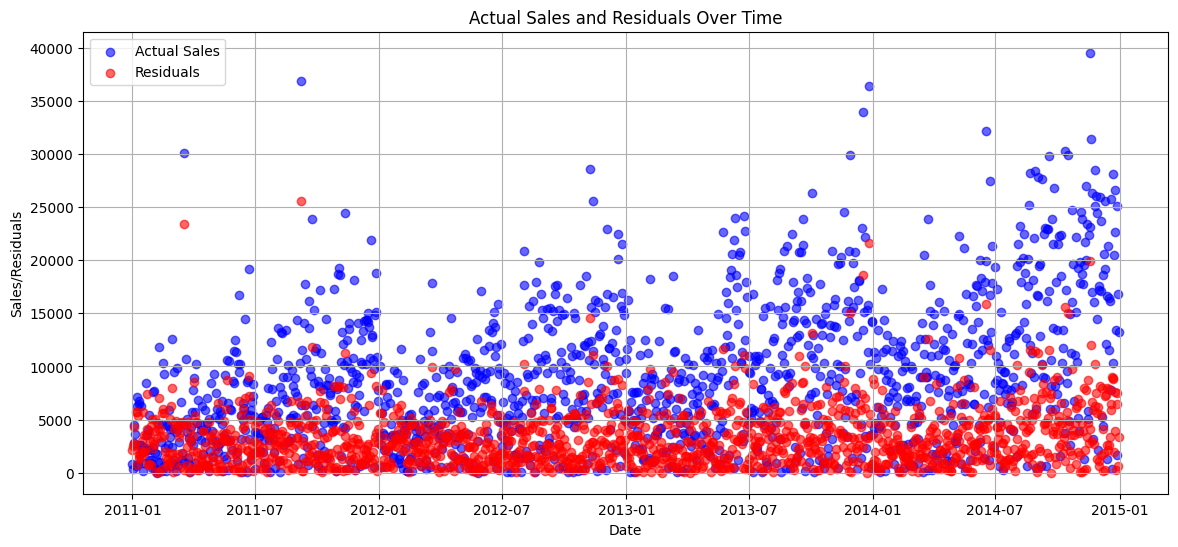

In [26]:
# plot a scatter chart of Actual vs residuals. Two scatter charts with time as well. One with actual sales and one with residuals. Time on x-axis, sales and residuals on y-axis.
# Color each point separately like Acutalsales with one color and residuals with another color. Add a legend to differentiate between the two.  
# I mean one scatter chart with actual sales and another scatter chart with residuals. Both with time on x-axis.
plt.figure(figsize=(14,6))
plt.scatter(evaluation_df['OrderDate'], evaluation_df['ActualSales'], color='blue', label='Actual Sales', alpha=0.6)
plt.scatter(evaluation_df['OrderDate'], evaluation_df['Residuals'], color='red', label='Residuals', alpha=0.6)
plt.title("Actual Sales and Residuals Over Time")   
plt.xlabel("Date")
plt.ylabel("Sales/Residuals")
plt.legend()
plt.grid(True)
plt.show()

### Standardize Residuals (Z-Score)

In [29]:
import numpy as np

residual_mean = evaluation_df['Residuals'].mean()
residual_std = evaluation_df['Residuals'].std()

evaluation_df['ZScore'] = (
    (evaluation_df['Residuals'] - residual_mean) / residual_std
)


In [30]:
evaluation_df['Anomaly'] = np.where(
    np.abs(evaluation_df['ZScore']) > 3,
    1,
    0
)
evaluation_df.head(5)

,OrderDate,PredictedSales,LowerBound,UpperBound,ActualSales,Residuals,ZScore,Anomaly
0,2011-01-01,2968.125384,-2250.111554,8169.195463,808.57,2159.555384,-0.408202,0
1,2011-01-02,-2201.699847,-7868.278158,3474.373191,314.22,2515.919847,-0.277774,0
2,2011-01-03,7292.190634,1594.803486,12837.795878,4503.54,2788.650634,-0.177956,0
3,2011-01-04,7082.312640,2032.430561,12919.688514,2808.87,4273.442640,0.365472,0
4,2011-01-05,6251.087680,542.945630,11824.279365,3662.31,2588.777680,-0.251109,0


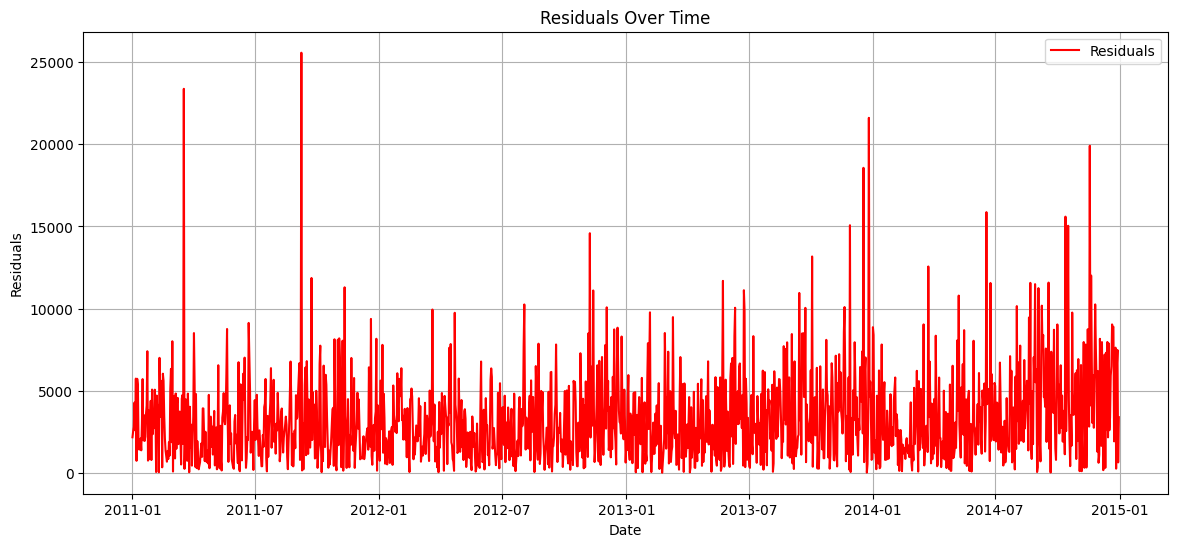

In [31]:
# plot residuals over time
plt.figure(figsize=(14,6))
plt.plot(evaluation_df['OrderDate'], evaluation_df['Residuals'], color='red', label='Residuals')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.legend()
plt.show()

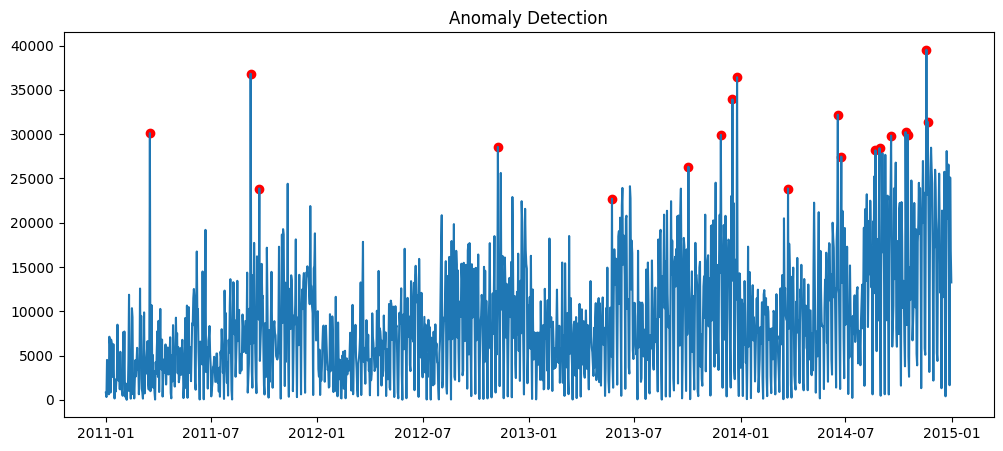

In [32]:
anomalies = evaluation_df[evaluation_df['Anomaly'] == 1]

plt.figure(figsize=(12,5))
plt.plot(evaluation_df['OrderDate'], evaluation_df['ActualSales'])
plt.scatter(anomalies['OrderDate'],
            anomalies['ActualSales'],
            color='red')
plt.title("Anomaly Detection")
plt.show()


### Writing Anomalies Back to SQL

In [34]:
anomaly_output = evaluation_df[['OrderDate',
                                 'ActualSales',
                                 'PredictedSales',
                                 'Residuals',
                                 'ZScore',
                                 'Anomaly']]


In [35]:
anomaly_output.to_sql(
    "FactSalesAnomaly",
    engine,
    if_exists="replace",
    index=False
)
print("Anomaly table written to SQL successfully!")

Anomaly table written to SQL successfully!
